## ValueInvestor: Stock Market Forecasting

## Background:
​
We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.
​
Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.
​
​
### Data Description:
​
You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.
​
### Goal(s):
​
Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.
​
### Success Metrics:
​
Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
import plotly.express as px
import random
import math

#for data download
import yfinance as yf

#facebook prophet for forecasting
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

#Data preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Statistical models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMAResults
from pylab import rcParams
import statsmodels.api as sm
import itertools

#keras
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers import Dense, SimpleRNN,LSTM, Dropout
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

### Data Download
Sber stock market data from YahooFinance API

In [2]:
# for today = datetime.today().strftime('%Y-%m-%d')
start_date = '2018-01-01' 
end_date = '2021-03-31'

Sber_df = yf.download('SBER.ME',start_date, end_date)

Sber_df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-24,283.399994,287.010010,282.260010,286.959991,270.153992,40318790
2021-03-25,286.500000,287.010010,283.850006,285.579987,268.854828,32071050
2021-03-26,288.630005,292.750000,288.320007,288.989990,272.065125,51572130
2021-03-29,289.720001,294.089996,289.269989,293.049988,275.887329,40847890
2021-03-30,294.859985,295.720001,291.500000,293.450012,276.263947,36333610


### Data Exploration

In [3]:
Sber_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
Sber_df.shape

(811, 6)

In [5]:
Sber_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 811 entries, 2018-01-03 to 2021-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       811 non-null    float64
 1   High       811 non-null    float64
 2   Low        811 non-null    float64
 3   Close      811 non-null    float64
 4   Adj Close  811 non-null    float64
 5   Volume     811 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 44.4 KB


In [6]:
Sber_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,811.000000,811.000000,811.000000,811.000000,811.000000,8.110000e+02
mean,226.562133,229.125721,223.843391,226.532540,167.387519,6.117821e+07
std,27.315533,27.314652,27.316434,27.318944,38.358953,3.354569e+07
min,170.199997,172.669998,165.899994,169.360001,112.513191,0.000000e+00
25%,205.294998,207.869995,203.364998,205.620003,138.350555,3.971421e+07
50%,226.759995,228.699997,224.149994,226.710007,160.458832,5.408402e+07
75%,242.165001,243.969994,240.110001,242.595001,180.433662,7.306501e+07
max,294.859985,296.070007,291.500000,293.450012,276.263947,2.630383e+08


* The dataset has no missing values. 
* The highest close price over the discussed time is 294.86 and the lowest value is 170.20

In [7]:
Sber_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Sber Stock Price History')

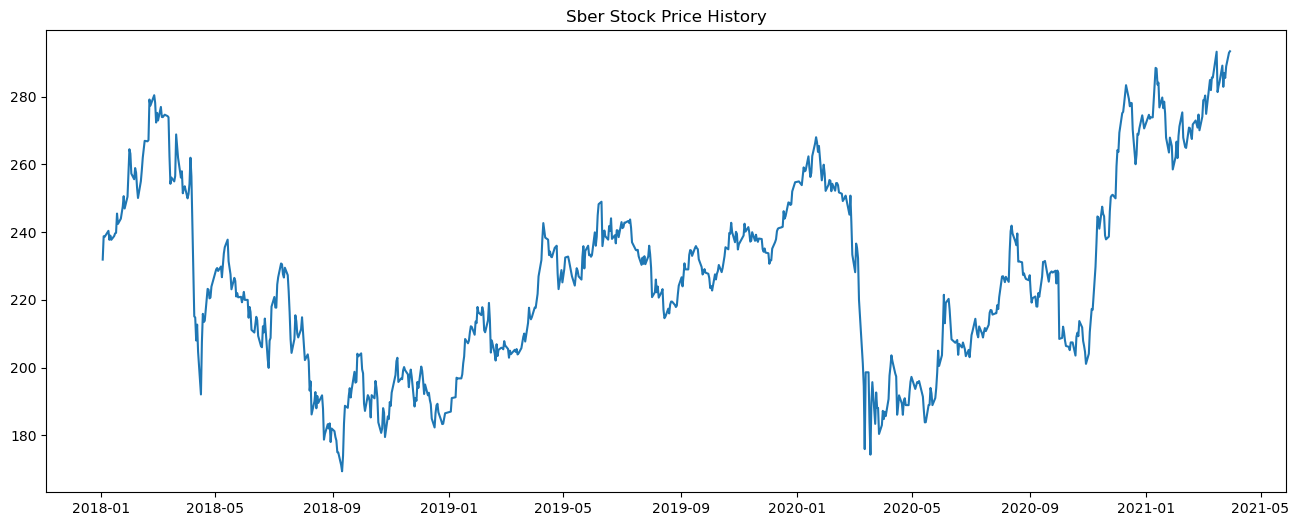

In [8]:
# Data Visualization
plt.figure(figsize=(16,6))
plt.plot(Sber_df["Close"], label='Price')
plt.title('Sber Stock Price History')

Due to the irregularity of the trend, it may be difficult to draw patterns from it.
However, the first quarter of each year except 2019 seem to has an incresase in price has increased in the first quarter of the year of 2021, comparing to the previous year. in the next vizualization we will check further for seasonality.

In [9]:
# first make a new columns for the months and the year
#add year column
Sber_df['year'] = [d.year for d in Sber_df.index]
years = Sber_df['year'].unique()

#add month column
Sber_df['month'] = [d.month for d in Sber_df.index]
months = Sber_df['month'].unique()

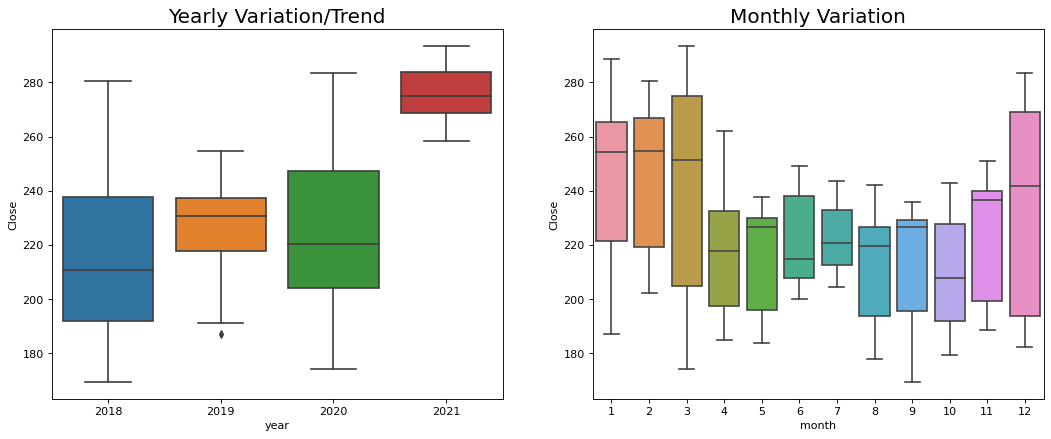

In [10]:
# Draw year_wise and month_wise box plots
fig, axes = plt.subplots(1, 2, figsize=(16,6), dpi= 80)
sns.boxplot(x='year', y='Close', data=Sber_df, ax=axes[0])
sns.boxplot(x='month', y='Close', data=Sber_df)

# Set Title
axes[0].set_title('Yearly Variation/Trend', fontsize=18); 
axes[1].set_title('Monthly Variation', fontsize=18)
plt.show()

From the Yearly boxplot, the year of 2018 and 2020 had a higher variance. While 2021 had just the first quarter in the year.
From the monthly boxplot, the month of March and December had higher variation in stock prices. It is clear our data does not contain seasonality but we will further use our statistical test to confirm this.

### Model Selection
First we will train and evaluate the following model and make a selection.
* fbprophet model
* ARIMA model
* ARIMAX / SARIMAX model
* Keras LSTM

### The Prophet Model

In [11]:
# Data Proprocessing for prophet model

columns = ['Date', 'Close']

p_df = Sber_df[["Close"]]
p_df=p_df.reset_index()

prophet_df = p_df.rename(columns={"Date": 'ds', 'Close':'y'})
#prophet_df['ds'] = pd.to_datetime(prophet_df["ds"])
prophet_df.head()

,ds,y
0,2018-01-03,231.899994
1,2018-01-04,238.800003
2,2018-01-05,238.600006
3,2018-01-09,240.399994
4,2018-01-10,237.759995


In [12]:
# Spltting the data into training and val set

train_set = prophet_df[prophet_df.ds < pd.to_datetime('2021-01-01')]
val_set = prophet_df[prophet_df.ds >= pd.to_datetime('2021-01-01')]

print(f'training data size : {train_set.shape}')
print(f'validation data size : {val_set.shape}')

training data size : (752, 2)
validation data size : (59, 2)


In [13]:
# traing the prophet model

np.random.seed(1)
prophet_m = Prophet()
prophet_m.fit(train_set)

02:07:26 - cmdstanpy - INFO - Chain [1] start processing
02:07:26 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Model Evaluation

prediction = prophet_m.predict(pd.DataFrame({'ds':val_set['ds']}))
y_actual = val_set['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print ("MAE of Prophet", mean_absolute_error(y_actual, y_predicted))
print ("MAPE of Prophet", np.mean(np.abs(y_predicted - y_actual)/np.abs(y_actual)))

MAE of Prophet 14.772879390393273
MAPE of Prophet nan


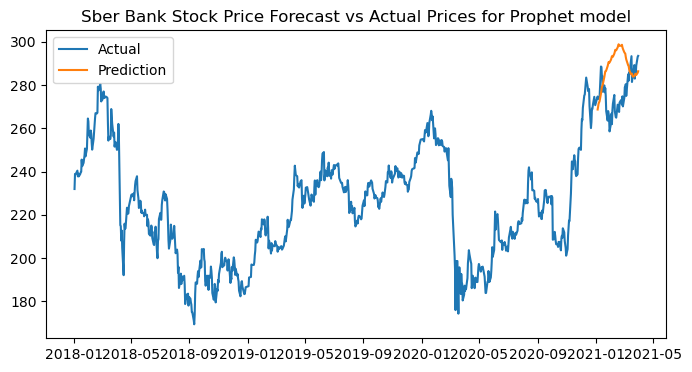

In [15]:
plt.figure(figsize=(8,4))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(prediction['ds'], prediction['yhat'], label='Prediction')
plt.title('Sber Bank Stock Price Forecast vs Actual Prices for Prophet model')
plt.legend()

The chart above shows clearly this univariate model is not ideal for a data with a complex trend.

**Multivariate Prophet Model**

In [16]:
# Data Proprocessing for prophet model
p_df = Sber_df[["Close", 'Open', 'High', 'Low', 'Volume']]
p_df=p_df.reset_index()

prophet_df = p_df.rename(columns={"Date": 'ds', 'Close':'y'})
#prophet_df['ds'] = pd.to_datetime(prophet_df["ds"])
prophet_df.head()

,ds,y,Open,High,Low,Volume
0,2018-01-03,231.899994,226.880005,232.699997,226.350006,34549624
1,2018-01-04,238.800003,232.130005,239.500000,231.000000,53598530
2,2018-01-05,238.600006,238.889999,239.949997,236.699997,31579385
3,2018-01-09,240.399994,239.029999,243.759995,239.009995,53172630
4,2018-01-10,237.759995,240.399994,241.250000,237.059998,39371730


In [17]:
# Spltting the data into training and val set

train_set = prophet_df[prophet_df.ds < pd.to_datetime('2021-01-01')]
val_set = prophet_df[prophet_df.ds >= pd.to_datetime('2021-01-01')]

print(f'training data size : {train_set.shape}')
print(f'validation data size : {val_set.shape}')

training data size : (752, 6)
validation data size : (59, 6)


In [18]:
np.random.seed(1)
prophet_m2 = Prophet()
prophet_m2.add_regressor("Open", standardize=False)
prophet_m2.add_regressor("High", standardize=False)
prophet_m2.add_regressor("Low", standardize=False)
prophet_m2.add_regressor("Volume", standardize=False)
prophet_m2.fit(train_set)

02:07:26 - cmdstanpy - INFO - Chain [1] start processing
02:07:27 - cmdstanpy - INFO - Chain [1] done processing
02:07:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:07:27 - cmdstanpy - INFO - Chain [1] start processing
02:07:32 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
forecast = prophet_m2.predict(val_set)
forecast = forecast [['ds', 'yhat']]
forecast.head()

,ds,yhat
0,2021-01-04,274.482272
1,2021-01-05,272.196155
2,2021-01-06,272.635881
3,2021-01-08,274.302552
4,2021-01-11,288.811067


In [20]:
val_set['yhat'] = forecast['yhat'].values
val_set.head()

,ds,y,Open,High,Low,Volume,yhat
752,2021-01-04,274.679993,274.670013,276.600006,272.540009,41277720,274.482272
753,2021-01-05,273.519989,274.670013,275.700012,270.279999,42179430,272.196155
754,2021-01-06,273.929993,275.940002,275.940002,271.619995,36784175,272.635881
755,2021-01-08,273.929993,273.929993,273.929993,273.929993,0,274.302552
756,2021-01-11,288.549988,282.859985,292.950012,279.480011,108435431,288.811067


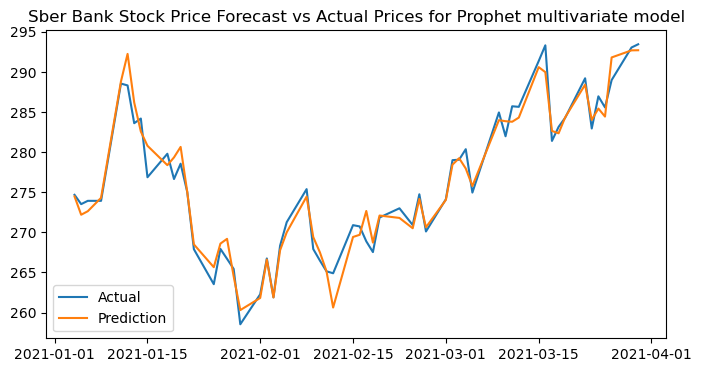

In [21]:
plt.figure(figsize=(8,4))
plt.plot(val_set['ds'], val_set['y'], label='Actual')
plt.plot(val_set['ds'], val_set['yhat'], label='Prediction')
plt.title('Sber Bank Stock Price Forecast vs Actual Prices for Prophet multivariate model')
plt.legend()

In [22]:
# Model Evaluation

y_actual = val_set['y']
y_predicted = val_set['yhat']
y_predicted = y_predicted.astype(int)
print ("MAE of Multivariate Prophet", mean_absolute_error(y_actual, y_predicted))
print ("MAPE of Multivariate Prophet", np.mean(np.abs(y_predicted - y_actual)/np.abs(y_actual)))

MAE of Multivariate Prophet 1.4111840199615995
MAPE of Multivariate Prophet 0.005085023736860351


In [433]:
# Save and Load Prophet model
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(prophet_m2))  # Save model

'''with open('serialized_model.json', 'r') as fin:
    prophet_m2 = model_from_json(fin.read())  # Load model'''

"with open('serialized_model.json', 'r') as fin:\n    prophet_m2 = model_from_json(fin.read())  # Load model"

The **Multivariate Prophet** model did much more better with a MAE of 1.41 and MAPE Mean Absolute Percentage Error of around 0.005, the model is 99.9% accurate in predicting the next 59 observations.

### ARIMA Model
This is the autoregressive integrated moving average model.
* Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
* Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
* Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA Parameters
* p: the number of lag observations in the model, also known as the lag order.
* d: the number of times the raw observations are differenced; also known as the degree of differencing.
* q: the size of the moving average window, also known as the order of the moving average.

#### Stationality Test: 
Before we move on to calculate our parameters for the model we have to test our data for stationality.
Here we will use the ADF(Augumented Dickey Fuller) test if the series is stationarity, so if the p-vale is;>/n 
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.>/n
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

* In an autoregressive integrated moving average model, the data are differenced in order to make it stationary. A model that shows stationarity is one that shows there is constancy to the data over time. Most economic and market data show trends, so the purpose of differencing is to remove any trends or seasonal structures. 
* Seasonality, or when data show regular and predictable patterns that repeat over a calendar year, could negatively affect the regression model. If a trend appears and stationarity is not evident, many of the computations throughout the process cannot be made and produce the intended results.


### Statistical tests

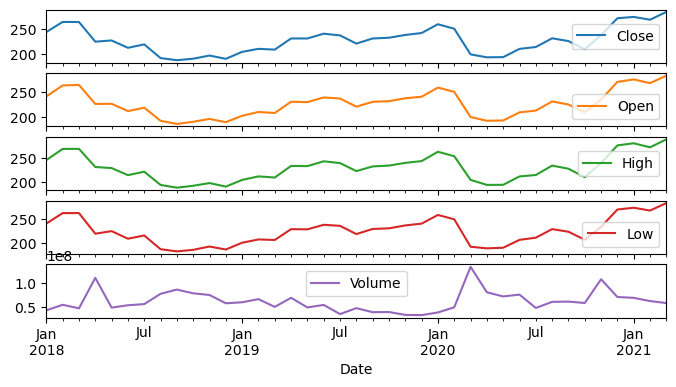

In [23]:
df_avg = Sber_df[["Close", 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
df_avg.plot(subplots=True, figsize = (8, 4))
plt.show()

In [24]:
# computing a 7 day rolling average

rolling_mean= Sber_df.Close.rolling(30).mean()
rolling_std= Sber_df.Close.rolling(30).std()
# viewing the dataset
print('rolling_mean:', rolling_mean.tail(),'\n')
print('rolling_std:', rolling_std.tail())

rolling_mean: Date
2021-03-24    277.386666
2021-03-25    277.975332
2021-03-26    278.725332
2021-03-29    279.655664
2021-03-30    280.607331
Name: Close, dtype: float64 

rolling_std: Date
2021-03-24    8.256731
2021-03-25    8.187778
2021-03-26    8.129737
2021-03-29    8.118424
2021-03-30    8.001594
Name: Close, dtype: float64


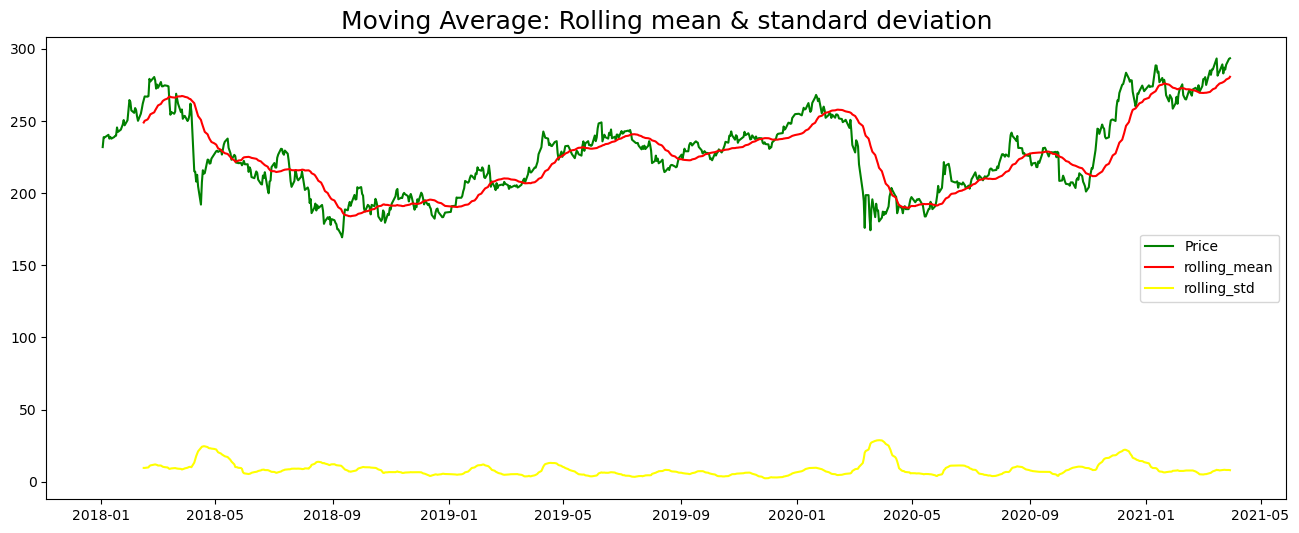

In [25]:
#plot rolling statistics
plt.figure(figsize=(16,6))
plt.plot(Sber_df.Close, color='green',label='Price')
plt.plot(rolling_mean, color='red',label='rolling_mean')
plt.plot(rolling_std, color='yellow',label='rolling_std')
plt.legend()
plt.title('Moving Average: Rolling mean & standard deviation',fontsize=18)
plt.show()

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary. Let's use the Augmented Dickey-Fuller test next.

In [26]:
print("Results of Dickey fuller test")
adf = adfuller(Sber_df.Close, autolag='AIC')
output = pd.Series(adf[0:4], index=['Test Statistics','p-value','Number of lags used','Number of observations used'])
for key,values in adf[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of Dickey fuller test
Test Statistics                 -1.882317
p-value                          0.340425
Number of lags used             11.000000
Number of observations used    799.000000
critical value (1%)             -3.438561
critical value (5%)             -2.865164
critical value (10%)            -2.568700
dtype: float64


We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is non-stationary.

* Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

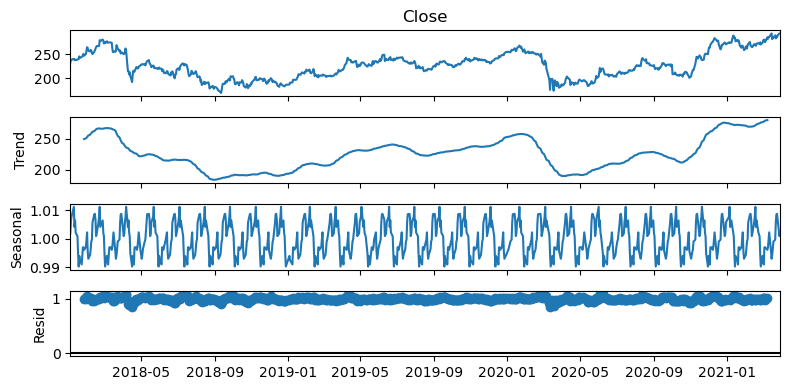

In [27]:
rcParams['figure.figsize'] = 8, 4
decomposition = sm.tsa.seasonal_decompose(Sber_df.Close, model='multiplicative', period=30)
fig = decomposition.plot()
plt.show()

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

#### Autoregression Function (ACF)

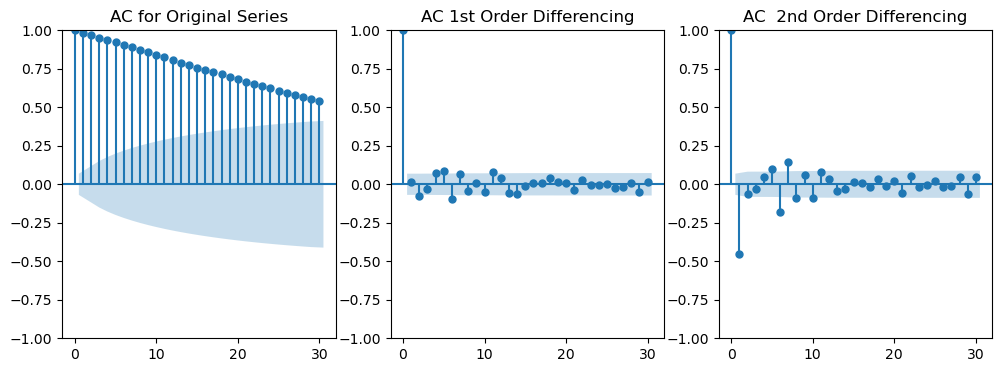

In [28]:
#Plot autocorrelation
# Original Series
fig, axes = plt.subplots(1, 3, figsize=(12,4))
plot_acf(Sber_df.Close, ax=axes[0])
axes[0].set_title('AC for Original Series')

# 1st Differencing
plot_acf(Sber_df.Close.diff().dropna(), ax=axes[1])
axes[1].set_title('AC 1st Order Differencing')

# 2nd Differencing
plot_acf(Sber_df.Close.diff().diff().dropna(), ax=axes[2])
axes[2].set_title('AC  2nd Order Differencing')

plt.show()

From the figs above, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag start going into the far negative zone, which indicates that the series might start being over differenced. Hence, we tentatively fix the order of **differencing as 1**.

Let's plot the partial autocorrelation to determine p.

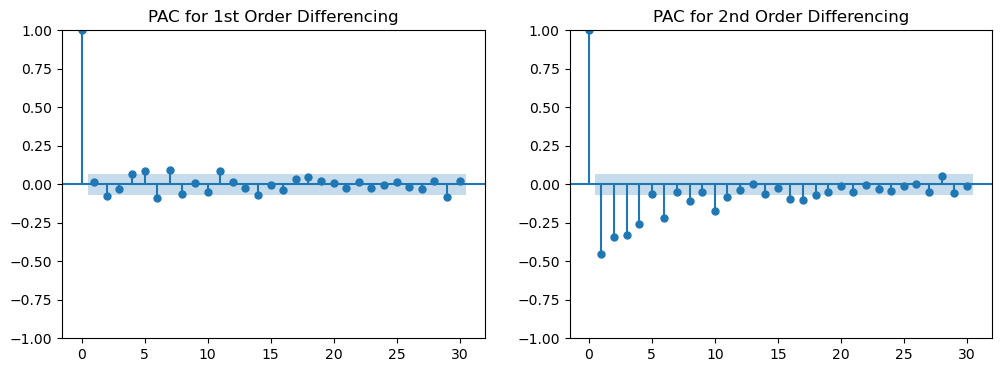

In [29]:
#Plot partial autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# 1st Differencing
plot_pacf(Sber_df.Close.diff().dropna(), ax=axes[0])
axes[0].set_title('PAC for 1st Order Differencing')

# 2nd Differencing
plot_pacf(Sber_df.Close.diff().diff().dropna(), ax=axes[1])
axes[1].set_title('PAC for 2nd Order Differencing')

plt.show()

We determine p based on the most significant lag in the partial autocorrelation plot. In the first plot, we see the 2nd lag is the most significant. Thus, we consider “p” to be 2, so p=2. Finally, q can be estimated similarly by looking at the ACF plot instead of the PACF plot. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. The ones with high correlation contribute more and would be enough to predict future values. so, from the plots of AC above, the moving average MA parameter can be set to 2. So q=2 Thus, our final ARIMA model can be defined as ARIMA(p=2, d=1,q= 2). This is statistically.

Now, we’ll utilize Auto ARIMA to find the best parameters.

**Auto ARIMA**: Automatically discover the optimal order for an ARIMA model.
The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model.

In [30]:
# Spltting the data into training and val set

a_df = Sber_df[["Close"]]
a_df=a_df.reset_index()

train = a_df[a_df.Date < pd.to_datetime('2021-01-01')]
val = a_df[a_df.Date >= pd.to_datetime('2021-01-01')]

print(f'training data size : {train.shape}')
print(f'validation data size : {val.shape}')

training data size : (752, 2)
validation data size : (59, 2)


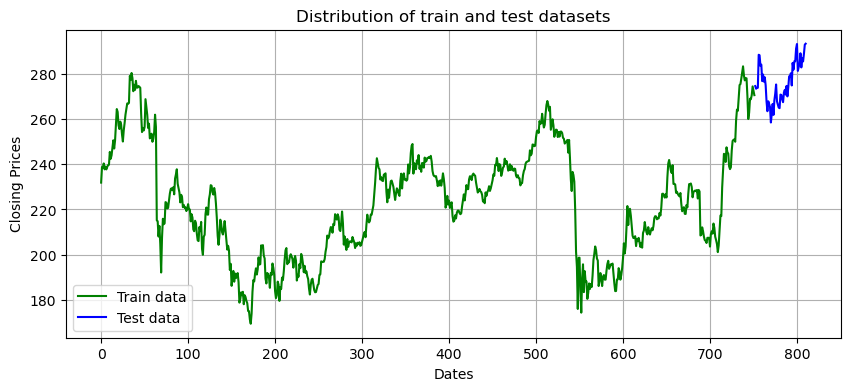

In [31]:
#plot the distribution of train and test
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.Close, 'green', label='Train data')
plt.plot(val.Close, 'blue', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4697.982, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4704.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4706.339, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4706.307, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4702.765, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4706.323, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4705.617, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4697.517, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4706.523, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4704.028, Time=1.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4699.485, Time=1.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4697.485, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4707.461, Time=0.45 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4699.484, Time=0.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

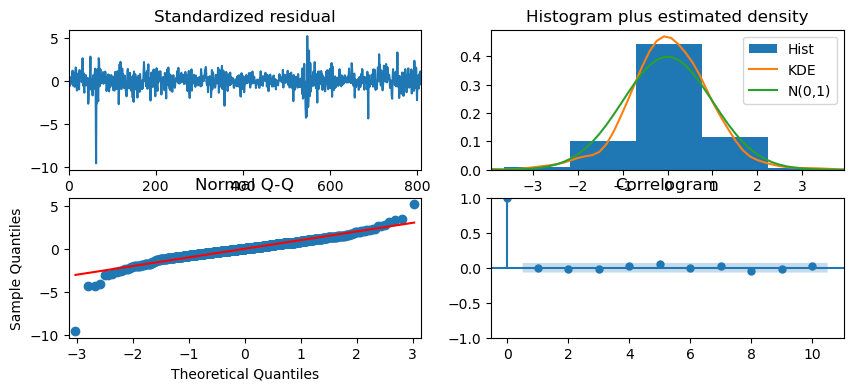

In [32]:
#Auto ARIMA:

model_autoARIMA = auto_arima(Sber_df.Close, seasonal=True,
                      trace=True,
                      suppress_warnings=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,4))
plt.show()

**Interpretations:**
* Standardized residual plot: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.
* Normal Q-Q plot: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.
* The density plot: The density plot on the top right suggests a normal distribution with a mean of zero.
* The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Spikes are close to zero which is evidence against autocorrelation. So stock prices aren't highly correlated.
So, the best model is ARIMA (p=4,d=1,q=4). Let's train the model

In [33]:
# Train ARIMA Model
arima_model = ARIMA(train.Close, order=(4,1,4))  
arima_model = arima_model.fit()  
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  752
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2167.997
Date:                Mon, 31 Jul 2023   AIC                           4353.995
Time:                        02:08:10   BIC                           4395.587
Sample:                             0   HQIC                          4370.020
                                - 752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0478      0.344      0.139      0.889      -0.626       0.721
ar.L2          0.1831      0.075      2.455      0.014       0.037       0.329
ar.L3         -0.8866      0.075    -11.839      0.0

In [34]:
print (Sber_df.shape)
print (train.shape)
print (val.shape)

(811, 8)
(752, 2)
(59, 2)


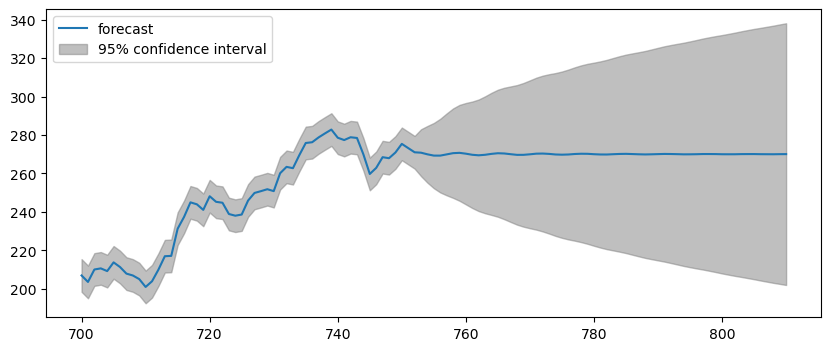

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
fig = plot_predict(arima_model, start=700, end= 810, ax=ax)
legend = ax.legend(loc="upper left")

Let's test also the ARIMA model with the previous paramethers, and see if AIC will be minimized or not.

In [36]:
# Train ARIMA Model
arima_model2 = ARIMA(train.Close, order=(2,1,2))  
arima_model2 = arima_model2.fit()  
print(arima_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  752
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2170.666
Date:                Mon, 31 Jul 2023   AIC                           4351.331
Time:                        02:08:11   BIC                           4374.438
Sample:                             0   HQIC                          4360.234
                                - 752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0896      0.038     28.316      0.000       1.014       1.165
ar.L2         -0.9318      0.038    -24.658      0.000      -1.006      -0.858
ma.L1         -1.1323      0.039    -29.306      0.0

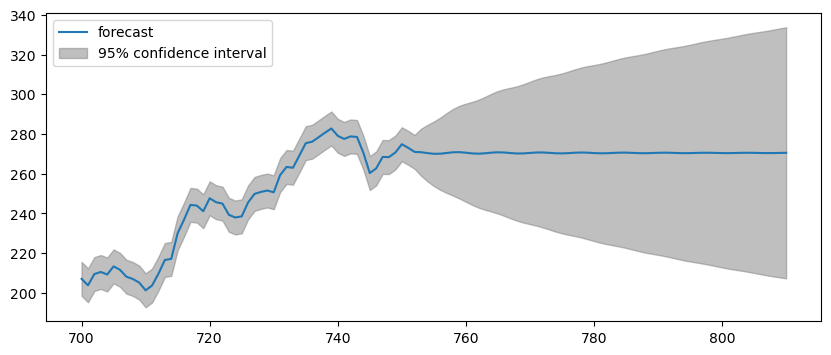

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
fig = plot_predict(arima_model2, start=700, end= 810, ax=ax)
legend = ax.legend(loc="upper left")

From the plot above, the actual observed values with the arima model lie within the 95% confidence band like the auto arima parameters model.

In [38]:
#get predicted prices
forecast_arima = arima_model.predict(start=752, end= 810 )
val["forecast_arima"] = forecast_arima.values

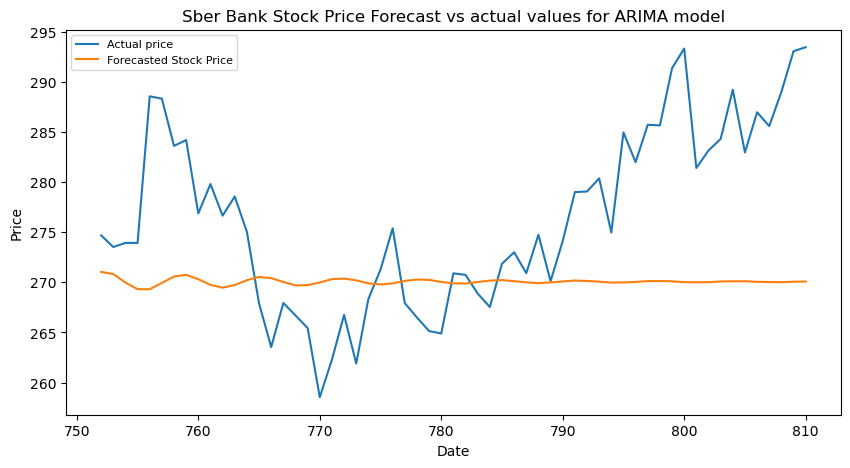

In [39]:
#Plot predicted vs actual prices
plt.figure(figsize=(10,5), dpi=100)
plt.plot(val.Close, label='Actual price')
plt.plot(val.forecast_arima, label='Forecasted Stock Price')
plt.title('Sber Bank Stock Price Forecast vs actual values for ARIMA model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [40]:
# Evaluate the ARIMA model

print("RMSE of ARIMA:", math.sqrt(mean_squared_error(val.Close, val.forecast_arima)))
print("MAE of ARIMA:", mean_absolute_error(val.Close, val.forecast_arima))
print("MAPE of ARIMA:", np.mean(np.abs(val.forecast_arima - val.Close)/np.abs(val.Close)))

RMSE of ARIMA: 10.950976196627227
MAE of ARIMA: 8.740635358164464
MAPE of ARIMA: 0.031023645645150002


#### ARIMAX model
ARIMAX is An Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX) model. ARIMAX is related to the ARIMA technique but, while ARIMA is suitable for datasets that are univariate. ARIMAX is suitable for analysis where there are additional explanatory variables (multivariate) in categorical and/or numeric format. Considering we need to foretell the stock price for a day, we cannot use the feature values of the same day since they will be unavailable at actual inference time.
So, I ought external characteristics or internal feature engineering to USE arimax and then to improve the model.
For that, I add some essential features like lag values of available numeric features widely accepted for time series problems, using the mean and the standard deviation of their lagged values. The following three sets of lagged values are used: one previous day, one looking back seven days and another looking back 30 days as a proxy for last week and last month metrics.

In [41]:
df = Sber_df.copy()
df.drop(['month','year','Adj Close'],axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-03,226.880005,232.699997,226.350006,231.899994,34549624
2018-01-04,232.130005,239.500000,231.000000,238.800003,53598530
2018-01-05,238.889999,239.949997,236.699997,238.600006,31579385
2018-01-09,239.029999,243.759995,239.009995,240.399994,53172630
2018-01-10,240.399994,241.250000,237.059998,237.759995,39371730


During boosting models, it is very beneficial to attach DateTime features like an hour, day, month, as appropriate to implement the model knowledge about the time element in the data.

In [42]:
#attach DateTime features like: week, day, month, day_of_week
df["month"] = [d.month for d in df.index]
df["week"] = [d.week for d in df.index]
df["day"] = [d.day for d in df.index]
df["day_of_week"] = [d.dayofweek for d in df.index]

df.loc[:,'month':'day_of_week'].head(7)

,month,week,day,day_of_week
Date,,,,
2018-01-03,1,1,3,2
2018-01-04,1,1,4,3
2018-01-05,1,1,5,4
2018-01-09,1,2,9,1
2018-01-10,1,2,10,2
2018-01-11,1,2,11,3
2018-01-12,1,2,12,4


In [43]:
#select exogenous features
exogenous_features=df.columns[0:].values.tolist()
exogenous_features.remove('Close')
exogenous_features

['Open', 'High', 'Low', 'Volume', 'month', 'week', 'day', 'day_of_week']

In [44]:
# split data into train and test

np.random.seed(1)
train_ARMX = df[df.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_ARMX = train_ARMX.dropna()
test_ARMX = df[df.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_ARMX = test_ARMX.dropna()

print('shape of train set: ',train_ARMX.shape)
print('shape of test set: ',test_ARMX.shape)

shape of train set:  (752, 9)
shape of test set:  (59, 9)


In [45]:
# create the ARIMAX model using auto arima for parameter selection
model_ARIMAX = auto_arima(train_ARMX.Close, exogenous=train_ARMX[exogenous_features], seasonal=True, 
                        trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4353.220, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4356.608, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4357.642, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4357.462, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4354.712, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4357.363, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4356.697, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4351.305, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4358.210, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4356.678, Time=1.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4353.304, Time=1.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4351.306, Time=0.95 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4355.687, Time=0.32 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4354.707, Time=1.69 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [46]:
model_ARIMAX.fit(train_ARMX.Close, exogenous=train_ARMX[exogenous_features])

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [47]:
#predict prices

forecast_ARMX = model_ARIMAX.predict(n_periods=len(test_ARMX), exogenous=test_ARMX[exogenous_features])
test_ARMX["Forecast_ARIMAX"] = forecast_ARMX.values

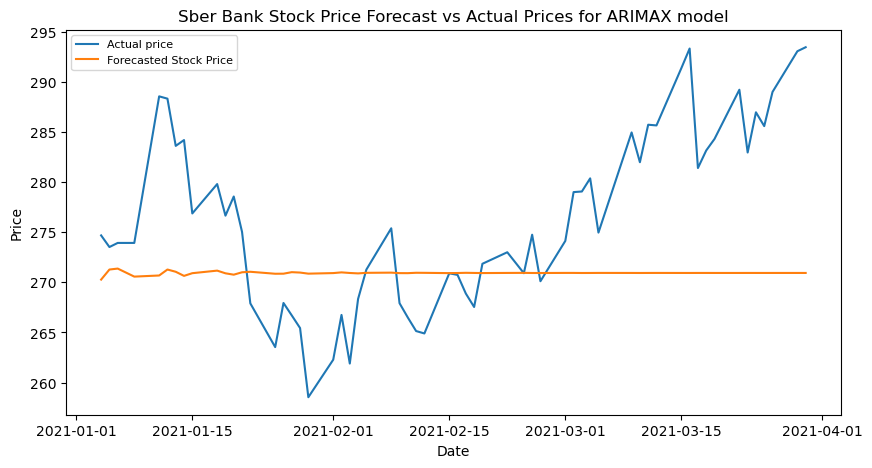

In [48]:
#Plot predicted vs actual prices
plt.figure(figsize=(10,5), dpi=100)
plt.plot(test_ARMX.Close, label='Actual price')
plt.plot(test_ARMX.Forecast_ARIMAX, label='Forecasted Stock Price')
plt.title('Sber Bank Stock Price Forecast vs Actual Prices for ARIMAX model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
# Evaluate the ARIMA model
print("RMSE of ARIMAX:", math.sqrt(mean_squared_error(test_ARMX.Close, test_ARMX.Forecast_ARIMAX)))
print("MAE of ARIMAX:", mean_absolute_error(test_ARMX.Close, test_ARMX.Forecast_ARIMAX))
print("MAPE of ARIMAX:", np.mean(np.abs(test_ARMX.Forecast_ARIMAX - test_ARMX.Close)/np.abs(test_ARMX.Close)))

RMSE of ARIMAX: 10.455185988357506
MAE of ARIMAX: 8.356709762481039
MAPE of ARIMAX: 0.02970080967182615


Although, the accuracy of both the ARIMA and ARIMAX is high but it forcasted poor with a high mean absolute error. Next we will train a seasonal arimax, since the data has seasonal trends.

#### Seasonal ARIMAX (SARIMAX)

In [50]:
# create the SARIMAX model using auto arima for parameter selection
model_SARIMAX = SARIMAX(endog=train_ARMX['Close'],
                exog=train_ARMX[exogenous_features], #only required if exog data is used
                order=(3, 1, 2),
                seasonal_order=(3, 1, 2, 12)).fit()

In [51]:
#predict prices

forecast_SARMX = model_SARIMAX.predict(start=752, end=810, dynamic=True, exog=test_ARMX[exogenous_features])
test_ARMX["Forecast_SARIMAX"] = forecast_SARMX.values

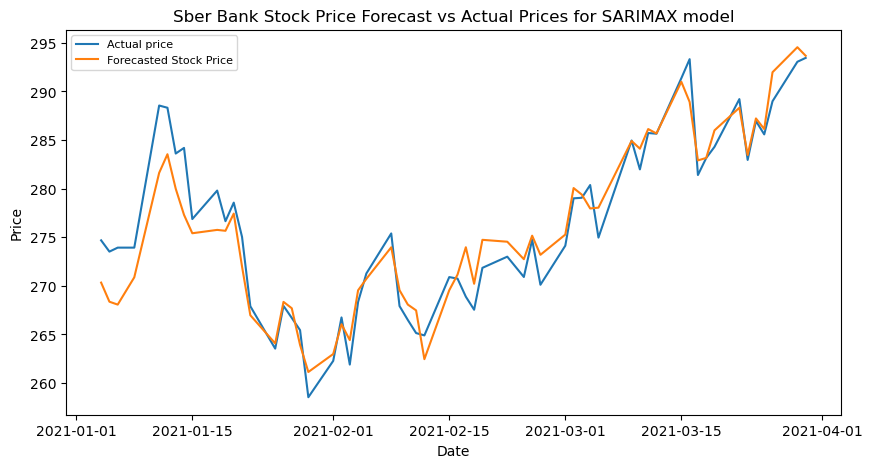

In [52]:
#Plot predicted vs actual prices
plt.figure(figsize=(10,5), dpi=100)
plt.plot(test_ARMX.Close, label='Actual price')
plt.plot(test_ARMX.Forecast_SARIMAX, label='Forecasted Stock Price')
plt.title('Sber Bank Stock Price Forecast vs Actual Prices for SARIMAX model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
# Evaluate the ARIMA model
print("RMSE of SARIMAX:", math.sqrt(mean_squared_error(test_ARMX.Close, test_ARMX.Forecast_SARIMAX)))
print("MAE of SARIMAX:", mean_absolute_error(test_ARMX.Close, test_ARMX.Forecast_SARIMAX))
print("MAPE of SARIMAX:", np.mean(np.abs(test_ARMX.Forecast_SARIMAX - test_ARMX.Close)/np.abs(test_ARMX.Close)))

RMSE of SARIMAX: 2.6306121251489656
MAE of SARIMAX: 2.0029309118579053
MAPE of SARIMAX: 0.007244985485871193


The **SARIMAX** model looks good! with a MAE of 2 and MAPE Mean Absolute Percentage Error of around 0.007, the model is 99.9% accurate in predicting the next 59 observations.

#### LSTM Model
Long short-term memory (LSTM) has a similar control flow as a recurrent neural network in the sense that it processes the data while passing on information as it propagates forward. The actual difference lies in the operations within the cells of the long short-term memory network. These operations allow the LSTM to keep or forget information. LSTMs enable backpropagation of the error through time and layers hence helping preserve them. An LSTM (Long short-term memory) model is an artificial recurrent neural network (RNN) architecture which has feedback connections, making it able to not only process single data points, but also entire sequences of data, making them better suited for predicting stock prices. 

LSTM has three gates:
* The input gate: The input gate adds information to the cell state,
* The forget gate: It removes the information that is no longer required by the model,
* The output gate: Output Gate at LSTM selects the information to be shown as output.

**Data preparation**

In [54]:
df1 = Sber_df.copy()
df1 = df1.reset_index()['Close']
df1.head()

0    231.899994
1    238.800003
2    238.600006
3    240.399994
4    237.759995
Name: Close, dtype: float64

In [55]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(811, 1)

In [56]:
# Train / Test Split

training_size=int(len(Sber_df[Sber_df.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]))
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]              
print('shape of train set: ',train_data.shape)
print('shape of test set: ',test_data.shape)

shape of train set:  (752, 1)
shape of test set:  (59, 1)


In [121]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [122]:
print('shape of train set: ', X_train.shape, y_train.shape)
print('shape of test set: ', X_test.shape, ytest.shape)

shape of train set:  (731, 20) (731,)
shape of test set:  (38, 20) (38,)


In [123]:
# While Implementing any LSTM, we should always reshape our X train in 3-D, 
# add 1 the reason behind is the time step and the 1 is given to the LSTM.

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print('shape of train set: ', X_train.shape)
print('shape of test set: ', X_test.shape)

shape of train set:  (731, 20, 1)
shape of test set:  (38, 20, 1)


In [124]:
# LSTM Model Initialization
np.random.seed(1)

model=Sequential()
model.add(LSTM(20,return_sequences=True,input_shape=(20,1)))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [125]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 20, 20)            1760      
                                                                 
 lstm_12 (LSTM)              (None, 20)                3280      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [126]:
#fit model
History = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/50
37/37 [==============================] - 6s 41ms/step - loss: 0.0518 - val_loss: 0.0154
Epoch 2/50
37/37 [==============================] - 1s 27ms/step - loss: 0.0082 - val_loss: 0.0102
Epoch 3/50
37/37 [==============================] - 1s 23ms/step - loss: 0.0067 - val_loss: 0.0112
Epoch 4/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0063 - val_loss: 0.0078
Epoch 5/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 6/50
37/37 [==============================] - 1s 22ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 7/50
37/37 [==============================] - 1s 18ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 8/50
37/37 [==============================] - 1s 24ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 9/50
37/37 [==============================] - 1s 24ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 10/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 11/

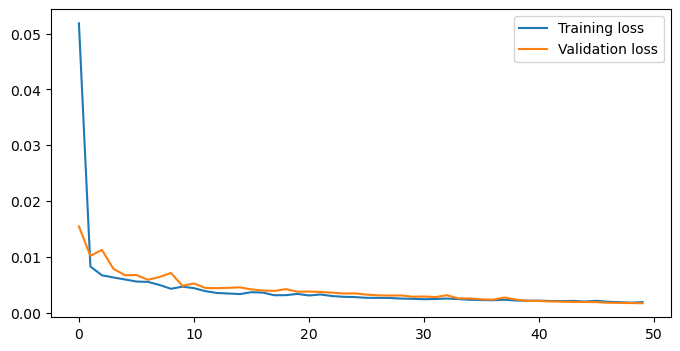

In [127]:
plt.plot(History.history['loss'], label='Training loss')
plt.plot(History.history['val_loss'], label = 'Validation loss')
plt.legend()

In [134]:
# Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)

2/2 [==============================] - 0s 22ms/step


In [135]:
math.sqrt(mean_squared_error(y_train,train_predict))

0.04110513552602579

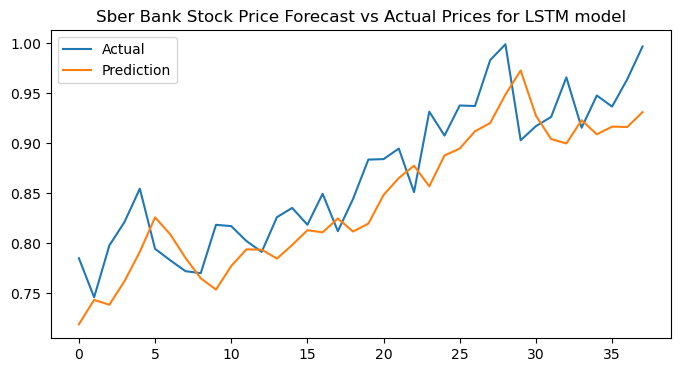

In [139]:
plt.figure(figsize=(8,4))
plt.plot(ytest, label='Actual')
plt.plot(test_predict, label='Prediction')
plt.title('Sber Bank Stock Price Forecast vs Actual Prices for LSTM model')
plt.legend()

### Bollinger bands

Bollinger Bands are a tool introduced by the quantitative trader John Bollinger in the 1980s. They are made by two lines that wrap the price time series in a way that is related to volatility. The higher the volatility, the wider the bands. They are usually drawn in this way:

Higher band: a 20-period Simple Moving Average plus 2 times the 20-period rolling standard deviation, both calculated on the close price
Lower band: a 20-period Simple Moving Average minus 2 times the 20-period rolling standard deviation, both calculated on the close price
What are the parameters of Bolliger bands?
Bollinger Bands have 2 parameters:
1- the period of the moving average and of the standard deviation (which is the same)
2- the multiplier of the standard deviation.

The 20-period SMA is often used to catch medium-term movements, so the value of 20 periods has been chosen empirically.
About The multiplier of the standard deviation, according to the normal distribution, there is a probability of nearly 95% that the value of a normal variable is more than 2 standard deviations far from the mean value. That’s where the 2 number comes from.

John Bollinger himself suggests using a slightly different set of parameters, changing the multiplier and the period according to some particular situations. Nevertheless, the 20–2 combination is widely considered almost like a standard in trading.

In [365]:
# Monthly Upper and Lower bands
df_bands=prophet_df[['y','Open',"ds"]]
period = 20
multiplier = 2
df_bands['UpperBand'] = df_bands['y'].rolling(period).mean() + df_bands['y'].rolling(period).std() * multiplier
df_bands['SMA'] = df_bands['y'].rolling(period).mean()
df_bands['LowerBand'] = df_bands['y'].rolling(period).mean() - df_bands['y'].rolling(period).std() * multiplier

In [366]:
# Weekly Upper and Lower bands
df_bands['UpperBand7'] = df_bands['y'].rolling(7).mean() + df_bands['y'].rolling(7).std() * multiplier
df_bands['SMA7'] = df_bands['y'].rolling(7).mean()
df_bands['LowerBand7'] = df_bands['y'].rolling(7).mean() - df_bands['y'].rolling(7).std() * multiplier
# Daily Upper and Lower bands
df_bands['UpperBand1'] = df_bands['y'].rolling(2).mean() + df_bands['y'].rolling(2).std() * multiplier
df_bands['SMA1'] = df_bands['y'].rolling(2).mean()
df_bands['LowerBand1'] = df_bands['y'].rolling(2).mean() - df_bands['y'].rolling(2).std() * multiplier

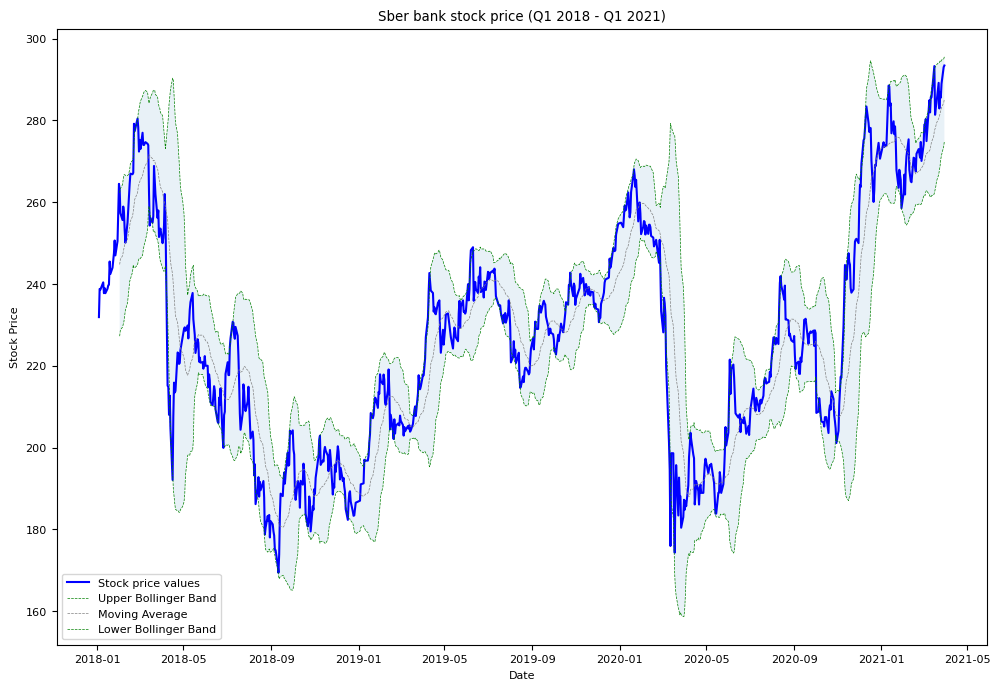

In [369]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rc('font', size=8)

plt.plot(df_bands['ds'], df_bands['y'], label = "Stock price values", color='blue',linewidth=1.5)
plt.plot(df_bands['ds'], df_bands['UpperBand'], label = "Upper Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'], df_bands['SMA'], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'], df_bands['LowerBand'], label = "Lower Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.fill_between(df_bands['ds'], df_bands['LowerBand'], df_bands['UpperBand'], alpha=0.1)
plt.title('Sber bank stock price (Q1 2018 - Q1 2021)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

The above fig shows how the Bollinger Bands wraps around the open and close prices just like expected.

So far, the multivariate Prophet and SARIMAX model has the best performance in terms of accuracy, MAE and MAPE. Now we will evaluate it using the Bollinger Bands and build our recommender.

In [170]:
train_set.shape

(752, 6)

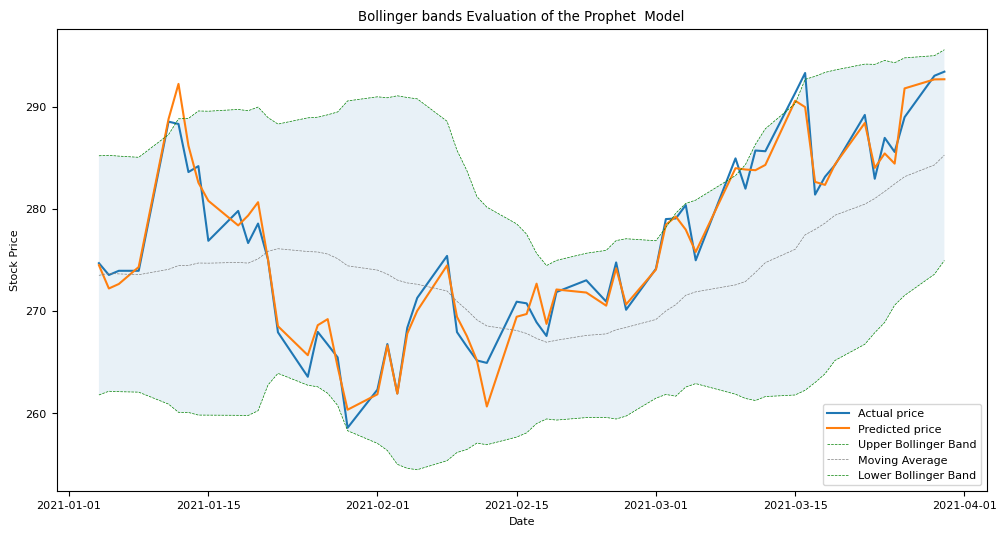

In [372]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rc('font', size=8)

plt.plot(df_bands['ds'][752:], df_bands['y'][752:], label = "Actual price")
plt.plot(val_set['ds'], val_set['yhat'], label = "Predicted price")
plt.plot(df_bands['ds'][752:], df_bands['UpperBand'][752:], label = "Upper Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['SMA'][752:], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['LowerBand'][752:], label = "Lower Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.fill_between(df_bands['ds'][752:], df_bands['LowerBand'][752:], df_bands['UpperBand'][752:], alpha=0.1)
plt.title('Bollinger bands Evaluation of the Prophet Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

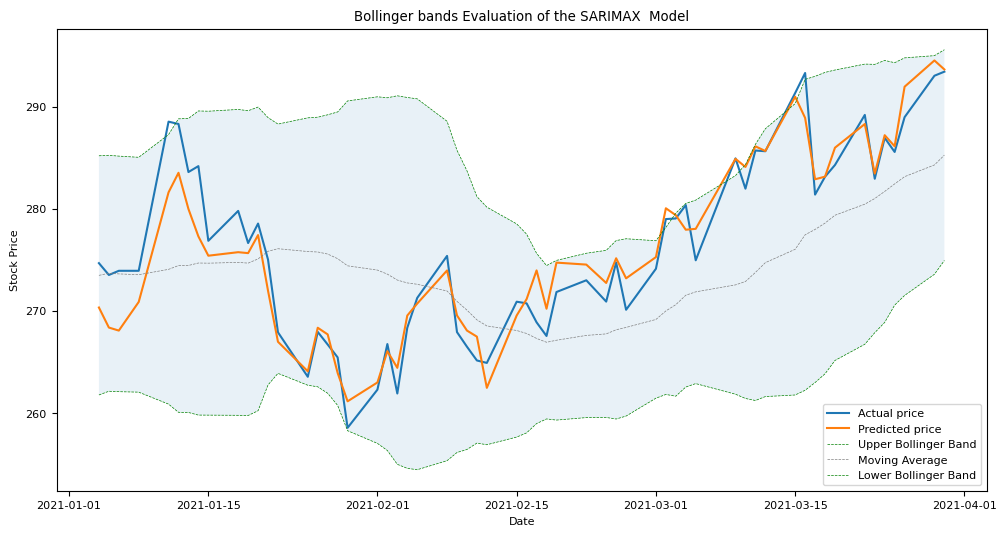

In [373]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rc('font', size=8)

plt.plot(df_bands['ds'][752:], df_bands['y'][752:], label = "Actual price")
plt.plot(df_bands['ds'][752:], test_ARMX['Forecast_SARIMAX'], label = "Predicted price")
plt.plot(df_bands['ds'][752:], df_bands['UpperBand'][752:], label = "Upper Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['SMA'][752:], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['LowerBand'][752:], label = "Lower Bollinger Band", color='green', linestyle="--", linewidth=0.5)
plt.fill_between(df_bands['ds'][752:], df_bands['LowerBand'][752:], df_bands['UpperBand'][752:], alpha=0.1)
plt.title('Bollinger bands Evaluation of the SARIMAX  Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Looks good! predicted values are mostly within the bands for both the prophet and SARIMAX

### Recommendation

In [426]:
Recommend = val_set.copy()
Recommend.drop(['Open','High','Low','Volume' ],axis=1,inplace=True)
Recommend = Recommend.rename(columns={'ds':"Date", 'y':'Price', "yhat":'Forecast'})
Recommend['Buy'] = np.nan
Recommend['Sell'] = np.nan
Recommend['Buy7'] = np.nan
Recommend['Sell7'] = np.nan
Recommend['Buy1'] = np.nan
Recommend['Sell1'] = np.nan
Recommend = Recommend.reset_index()

In [427]:
# Set hold ,buy and sell for Daily recommendation
for i in range(1, Recommend.shape[0]):
    if Recommend['Forecast'][i]>= df_bands['UpperBand1'][i]:
        Recommend["Sell1"][i] = Recommend['Forecast'][i]
        
    elif Recommend['Forecast'][i]<= df_bands['LowerBand1'][i]:
          Recommend["Buy1"][i]= Recommend['Forecast'][i]

In [428]:
# Set hold ,buy and sell for Weekly recommendation
for i in range(1, Recommend.shape[0]):
    if Recommend['Forecast'][i]>= df_bands['UpperBand7'][i]:
        Recommend["Sell7"][i] = Recommend['Forecast'][i]
        
    elif Recommend['Forecast'][i]<= df_bands['LowerBand7'][i]:
          Recommend["Buy7"][i]= Recommend['Forecast'][i]
    Recommend['Buy7'][i] = Recommend['Buy1'][i]
    

In [429]:
# Set hold ,buy and sell for monthly recommendation
for i in range(1, Recommend.shape[0]):
    if Recommend['Forecast'][i]>= df_bands['UpperBand'][i]:
        Recommend["Sell"][i] = Recommend['Forecast'][i]
        
    elif Recommend['Forecast'][i]<= df_bands['LowerBand'][i]:
          Recommend["Buy"][i]= Recommend['Forecast'][i]
    Recommend['Buy'][i] = Recommend['Buy1'][i]

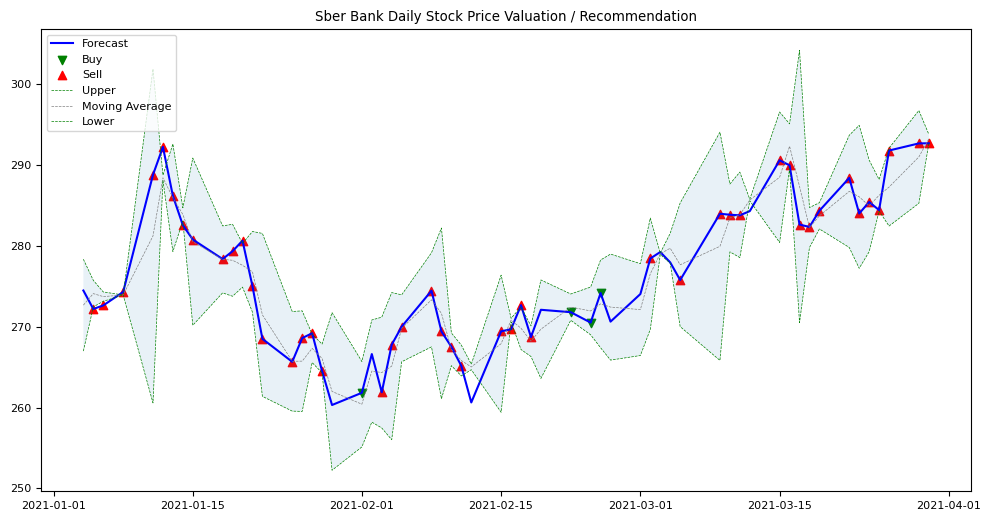

In [430]:
plt.figure(figsize=(12,6))
plt.plot(Recommend['Date'], Recommend['Forecast'], label='Forecast', color='blue',linewidth=1.5) #Forecast price
plt.scatter(Recommend['Date'], Recommend['Buy1'], label='Buy', color='green', marker='v') #Buy Signal
plt.scatter(Recommend['Date'], Recommend['Sell1'], label='Sell', color='red', marker='^') #Sell Signal
plt.plot(df_bands['ds'][752:], df_bands['UpperBand1'][752:], label='Upper', color='green', linestyle="--", linewidth=0.5) #Upper band
plt.plot(df_bands['ds'][752:], df_bands['SMA1'][752:], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['LowerBand1'][752:], label='Lower', color='green', linestyle="--", linewidth=0.5) #lower band
plt.fill_between(df_bands['ds'][752:], df_bands['LowerBand1'][752:], df_bands['UpperBand1'][752:], alpha=0.1)
plt.title("Sber Bank Daily Stock Price Valuation / Recommendation")
plt.legend(loc='upper left')
plt.show()

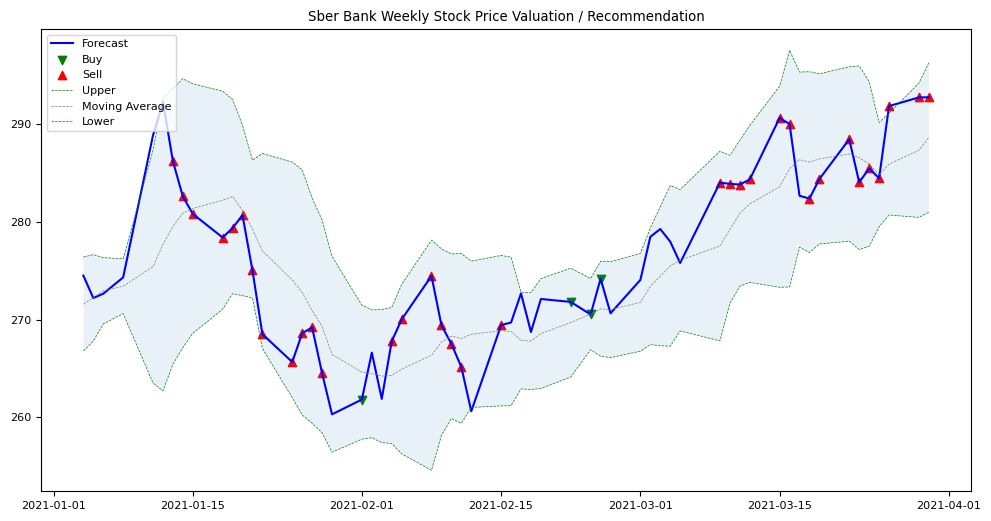

In [431]:
plt.figure(figsize=(12,6))
plt.plot(Recommend['Date'], Recommend['Forecast'], label='Forecast', color='blue') #Forecast price
plt.scatter(Recommend['Date'], Recommend['Buy7'], label='Buy', color='green', marker='v') #Buy Signal
plt.scatter(Recommend['Date'], Recommend['Sell7'], label='Sell', color='red', marker='^') #Sell Signal
plt.plot(df_bands['ds'][752:], df_bands['UpperBand7'][752:], label='Upper', color='green', linestyle="--", linewidth=0.5) #Upper band
plt.plot(df_bands['ds'][752:], df_bands['SMA7'][752:], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)
plt.plot(df_bands['ds'][752:], df_bands['LowerBand7'][752:], label='Lower', color='green', linestyle="--", linewidth=0.5) #lower band
plt.fill_between(df_bands['ds'][752:], df_bands['LowerBand7'][752:], df_bands['UpperBand7'][752:], alpha=0.1)
plt.title("Sber Bank Weekly Stock Price Valuation / Recommendation")
plt.legend(loc='upper left')
plt.show()

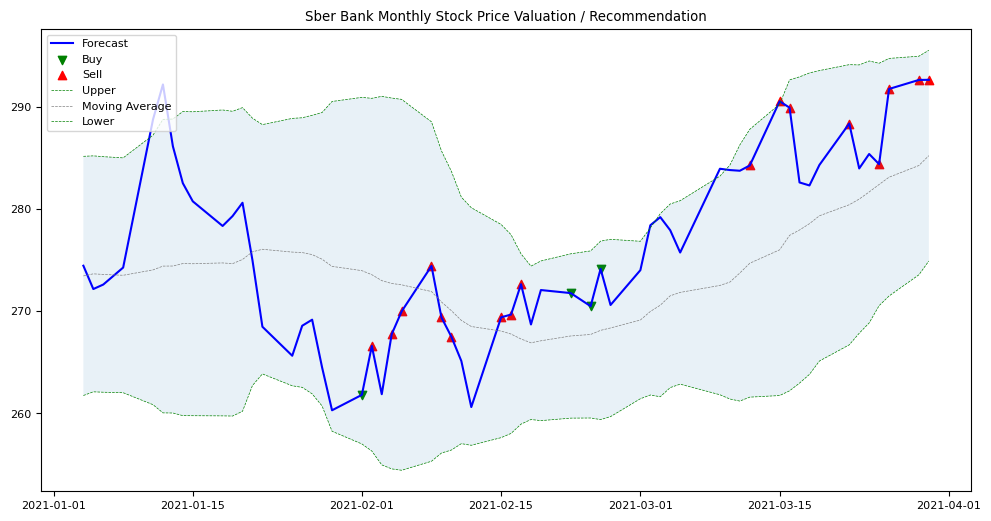

In [432]:
plt.figure(figsize=(12,6))
plt.plot(Recommend['Date'], Recommend['Forecast'], label='Forecast', color='blue') #Forecast price
plt.scatter(Recommend['Date'], Recommend['Buy'], label='Buy', color='green', marker='v',) #Buy Signal
plt.scatter(Recommend['Date'], Recommend['Sell'], label='Sell', color='red', marker='^') #Sell Signal
plt.plot(df_bands['ds'][752:], df_bands['UpperBand'][752:], label='Upper', color='green', linestyle="--", linewidth=0.5) #Upper band
plt.plot(df_bands['ds'][752:], df_bands['SMA'][752:], label = "Moving Average", color='gray', linestyle="--", linewidth=0.5)#Average
plt.plot(df_bands['ds'][752:], df_bands['LowerBand'][752:], label='Lower', color='green', linestyle="--", linewidth=0.5) #lower band
plt.fill_between(df_bands['ds'][752:], df_bands['LowerBand'][752:], df_bands['UpperBand'][752:], alpha=0.1)
plt.title("Sber Bank Monthly Stock Price Valuation / Recommendation")
plt.legend(loc='upper left')
plt.show()

### Conclusion

In conclusion, we met the goal of the project to predict stock price valuations on a daily, weekly and monthly basis and recommend BUY, HOLD, SELL decisions. Here is my methodology:

* Read and explored the data
* Visualized data with multi plots techniques
* Preprocessed the data
* Used 4 different models for the modeling part:
    * 1 additive regression model (Prophet by Facebook)
    * 2 statistical models(ARIMA/ARIMAX and SARIMAX)
    * 1 deep learning model (LSTM).
* Compared forecasting results
* Used Bollinger Bands technique to visualize my forecasting prices
* Made recommendations to either Buy, Sell, or Hold.

After comparison, the multivariate Prophet and SARIMAX model had the best performance in terms of accuracy, MAE, and MAPE. The Multivariate Prophet was the selected model with an MAE of 1.41 and MAPE Mean Absolute Percentage Error of around 0.005, the model is 99.9% accurate. Further evaluation was using the Bollinger Bands.